In [2]:
from pprint import PrettyPrinter

import sys
sys.path.insert(0, '/home/dom/AIR/air25')

# Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import bm25s as bm25
import Stemmer
from src.config import CLAIMS_PATH, EVIDENCE_PATH, MAPPINGS_PATH

In [3]:
# Load Data

claims = pd.read_csv(CLAIMS_PATH)
evidences = pd.read_csv(EVIDENCE_PATH)
mappings = pd.read_csv(MAPPINGS_PATH)

In [4]:
# Index

stemmer = Stemmer.Stemmer("english")
evidence_texts = evidences["evidence"].fillna("").values
corpus_stemmed = bm25.tokenize(evidence_texts, stopwords="en", stemmer=stemmer)

retriever = bm25.BM25()
retriever.index(corpus_stemmed)

In [5]:
# Ground Truth

evidence_id_to_idx = {eid: idx for idx, eid in enumerate(evidences['evidence_id'])}
idx_to_claim_id = dict(enumerate(claims['claim_id']))

ground_truth = defaultdict(set)
for _, row in mappings.iterrows():
    if row['label'] in ['SUPPORTS', 'REFUTES'] and row['evidence_id'] in evidence_id_to_idx:
        ground_truth[row['claim_id']].add(evidence_id_to_idx[row['evidence_id']])

ground_truth = dict(ground_truth)

In [6]:
# BM25

def retrieve_bm25(claim_text, k=10):
    query_tokens = bm25.tokenize(claim_text, stemmer=stemmer, show_progress=False)
    results = retriever.retrieve(query_tokens, k=k, show_progress=False)
    return list(zip(results.documents[0], results.scores[0]))

def retrieve_all_bm25(claims_df, k=10):
    all_retrieved = []
    for _, row in tqdm(claims_df.iterrows(), total=len(claims_df), desc=f"Retrieving top-{k}"):
        retrieved = retrieve_bm25(row['claim'], k=k)
        all_retrieved.append(retrieved)
    return all_retrieved

In [7]:
# Eval Function

def evaluate_retrieval(claims_df, ground_truth, idx_to_claim_id, k=10):
    retrieved = retrieve_all_bm25(claims_df, k=k)

    results = []
    for row_idx, claim_id in idx_to_claim_id.items():
        if claim_id not in ground_truth:
            continue

        expected = ground_truth[claim_id]
        retrieved_idx = {idx for idx, _ in retrieved[row_idx]}
        hits = expected & retrieved_idx

        results.append({
            'claim_id': claim_id,
            'expected': len(expected),
            'found': len(hits),
            'recall': len(hits) / len(expected)
        })

    return pd.DataFrame(results), retrieved

In [8]:
# Recall@k

k_values = [5, 10, 20, 50, 100]
recall_scores = []

for k in k_values:
    results_df, _ = evaluate_retrieval(claims, ground_truth, idx_to_claim_id, k=k)
    mean_recall = results_df['recall'].mean()
    recall_scores.append(mean_recall)
    print(f"Recall@{k:3d}: {mean_recall:.2%}")

Retrieving top-5: 100%|██████████| 1377/1377 [00:00<00:00, 2732.61it/s]


Recall@  5: 32.78%


Retrieving top-10: 100%|██████████| 1377/1377 [00:00<00:00, 2879.13it/s]


Recall@ 10: 42.43%


Retrieving top-20: 100%|██████████| 1377/1377 [00:00<00:00, 2860.26it/s]


Recall@ 20: 51.05%


Retrieving top-50: 100%|██████████| 1377/1377 [00:00<00:00, 2820.81it/s]


Recall@ 50: 62.83%


Retrieving top-100: 100%|██████████| 1377/1377 [00:00<00:00, 2470.01it/s]

Recall@100: 71.98%


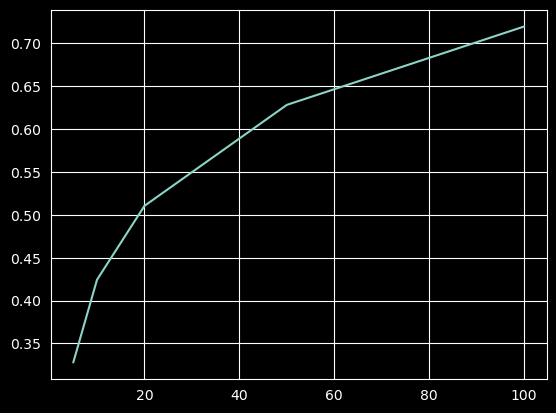

In [9]:
# Plot Recall@k

plt.plot(k_values, recall_scores)
plt.show()

In [10]:
# Results

results_df, retrieved = evaluate_retrieval(claims, ground_truth, idx_to_claim_id, k=50)

print(f"Mean Recall: {results_df['recall'].mean():.2%}")
print(f"Perfect Recall: {(results_df['recall'] == 1).sum()} / {len(results_df)}")
print(f"Zero Recall: {(results_df['recall'] == 0).sum()} / {len(results_df)}")

Retrieving top-50: 100%|██████████| 1377/1377 [00:00<00:00, 2804.65it/s]

Mean Recall: 62.83%
Perfect Recall: 405 / 902
Zero Recall: 190 / 902


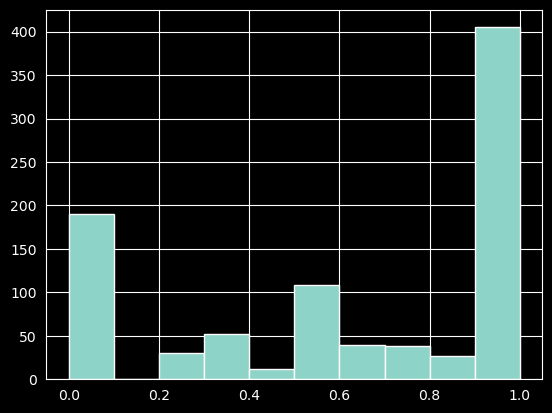

In [11]:
# Plot Distribution

plt.hist(results_df['recall'])
plt.show()

In [12]:
# MRR

def compute_mrr(retrieved, ground_truth, idx_to_claim_id):
    rrs = []
    for row_idx, claim_id in idx_to_claim_id.items():
        if claim_id not in ground_truth:
            continue
        expected = ground_truth[claim_id]
        for rank, (idx, _) in enumerate(retrieved[row_idx], 1):
            if idx in expected:
                rrs.append(1 / rank)
                break
        else:
            rrs.append(0)
    return np.mean(rrs)

In [13]:
# Precision@k

def compute_precision_at_k(retrieved, ground_truth, idx_to_claim_id, k):
    precisions = []
    for row_idx, claim_id in idx_to_claim_id.items():
        if claim_id not in ground_truth:
            continue
        expected = ground_truth[claim_id]
        retrieved_idx = {idx for idx, _ in retrieved[row_idx][:k]}
        precisions.append(len(retrieved_idx & expected) / k)
    return np.mean(precisions)

In [14]:
# Save

per_claim_recalls = results_df['recall'].values

results_dict = {
    'approach': 'Sparse',
    'k_values': k_values,
    'recall_scores': recall_scores,
    'mrr': compute_mrr(retrieved, ground_truth, idx_to_claim_id),
    'precision_at_k': {k: compute_precision_at_k(retrieved, ground_truth, idx_to_claim_id, k) for k in k_values},
    'per_claim_recalls': per_claim_recalls,
    'claim_ids': list(results_df['claim_id']),
}

np.save('results_a1.npy', results_dict)